In [61]:
MAX_TIME = 30
INIT_SIZE = 10
DEVICE = "cpu" # "cuda:0"

In [62]:
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '14-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
experiment_name

'14-torch_bartz08-2_1min_5init_2023-05-18_20-22-10'

# Chapter 14: Sequential Parameter Optimization Compared to Ray Tune
## Hyperparameter Tuning: pytorch wth cifar10 Data

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).


In [63]:
pip list | grep  "spot[RiverPython]"

spotPython                                0.1.1
spotRiver                                 0.0.81
Note: you may need to restart the kernel to use updated packages.


In [64]:
pip list | grep  "torch"

torch                                     2.0.0
torchvision                               0.15.1
Note: you may need to restart the kernel to use updated packages.


In [65]:
import sys
!{sys.executable} --version

Python 3.10.6


In [66]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython


In [67]:
from tabulate import tabulate
import warnings
import json
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    get_bound_values,
    get_default_values,
    get_var_name,
    get_var_type,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
)
from spotPython.torch.traintest import (
    evaluate_cv,
    evaluate_hold_out,
    train_save,
    test_saved,
    )
from spotPython.utils.eda import gen_design_table
from spotPython.utils.transform import transform_hyper_parameter_values
from spotPython.utils.init import fun_control_init

from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch
from spotPython.torch.netcifar10 import Net_CIFAR10

warnings.filterwarnings("ignore")

In [68]:
print(torch.__version__)
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS device: ", mps_device)

2.0.0
MPS device:  mps


## 0. Initialization of the Empty `fun_control` Dictionary

In [69]:
fun_control = fun_control_init()

## 1. Load Cifar10 Data 

The data loading is implemented as in the Section "Data loaders" in the PyTorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html).

In [70]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

In [71]:
train, test = load_data()
train.data.shape, test.data.shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [72]:
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": None, # dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": None})

## 2. Specification of the Preprocessing Model

Because the Ray Tune hyperparameter tuning does not use a preprocessing model, the preprocessing model is set to `None` here.

In [73]:
# categorical_columns = []
# one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# prep_model = ColumnTransformer(
#         transformers=[
#             ("categorical", one_hot_encoder, categorical_columns),
#         ],
#         remainder=StandardScaler(),
#     )
prep_model = None
fun_control.update({"prep_model": prep_model})

## 3. Select `algorithm` and `core_model_hyper_dict`

The same model as implemented as in the Section "Configurable neural network" in the PyTorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) is used here. `spotPython` implements a class which is similar to the class described in the PyTorch tutorial. The class is called `Net_CIFAR10`   and is implemented in the file `netcifar10.py`. The class is imported here.

Note: In addition to the class Net from the PyTorch tutorial, the class Net_CIFAR10 has additional attributes, namely:

* learning rate (`lr`),
* batchsize (`batch_size`),
* epochs (`epochs`), and
* k_folds (`k_folds`).

Further attributes can be easily added to the class, e.g., `optimizer` or `loss_function`.

In [74]:
core_model = Net_CIFAR10
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename=None)

### The `hyper_dict` Hyperparameters for the Selected Algorithm

`spotPython` uses simple `JSON` files for the specification of the hyperparameters. The `JSON` file for the `core_model` is called `torch_hyper_dict.json`. The corresponding entries for the `Net_CIFAR10` class are shown below.

```json
{"Net_CIFAR10":
    {
        "l1": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "l2": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "lr": {
            "type": "float",
            "default": 1e-03,
            "transform": "None",
            "lower": 1e-05,
            "upper": 1e-02},
        "batch_size": {
            "type": "int",
            "default": 4,
            "transform": "transform_power_2_int",
            "lower": 1,
            "upper": 4},
        "epochs": {
                "type": "int",
                "default": 3,
                "transform": "transform_power_2_int",
                "lower": 1,
                "upper": 4},
        "k_folds": {
            "type": "int",
            "default": 2,
            "transform": "None",
            "lower": 2,
            "upper": 3},
        "patience": {
            "type": "int",
            "default": 5,
            "transform": "None",
            "lower": 2,
            "upper": 10},
    }
}
```

Each entry in the `JSON` file represents one hyperparameter with the following structure:
`type`, `default`, `transform`, `lower`, and `upper`.


### Categorical Hyperparameters

In contrast to Ray Tune, `spotPython` can handle numerical, boolean, and categorical hyperparameters. Since `Ray Tune` does not tune categorical hyperparameters, they are not used here. However, they can be specified in the `JSON` file in a similar way as the numerical hyperparameters as shown below:

```json
"factor_hyperparameter": {
    "levels": ["A", "B", "C"],
    "type": "factor",
    "default": "B",
    "transform": "None",
    "core_model_parameter_type": "str",
    "lower": 0,
    "upper": 2},
```

## 4. Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

After specifying the model, the corresponding hyperparameters, their types and bounds are loaded from the `JSON` file `torch_hyper_dict.json`. After loading, the user can modify the hyperparameters, e.g., the bounds.
`spotPython` provides a clever rule for de-activating hyperparameters. If the lower and the upper bound are set to identical values, the hyperparameter is de-activated. This is useful for the hyperparameter tuning, because it allows to specify a hyperparameter in the `JSON` file, but to de-activate it in the `fun_control` dictionary. This is done in the next step.

### Modify hyperparameter of type numeric and integer (boolean)

Since the hyperparameter `k_folds` is not used in the PyTorch tutorial, it is de-activated here by setting the lower and upper bound to the same value.

In [75]:
fun_control = modify_hyper_parameter_bounds(fun_control, "batch_size", bounds=[1, 5])
fun_control = modify_hyper_parameter_bounds(fun_control, "k_folds", bounds=[0, 0])
fun_control = modify_hyper_parameter_bounds(fun_control, "patience", bounds=[5, 5])
fun_control["core_model_hyper_dict"]

{'l1': {'type': 'int',
  'default': 5,
  'transform': 'transform_power_2_int',
  'lower': 2,
  'upper': 9},
 'l2': {'type': 'int',
  'default': 5,
  'transform': 'transform_power_2_int',
  'lower': 2,
  'upper': 9},
 'lr': {'type': 'float',
  'default': 0.001,
  'transform': 'None',
  'lower': 1e-05,
  'upper': 0.01},
 'batch_size': {'type': 'int',
  'default': 4,
  'transform': 'transform_power_2_int',
  'lower': 1,
  'upper': 5},
 'epochs': {'type': 'int',
  'default': 3,
  'transform': 'transform_power_2_int',
  'lower': 3,
  'upper': 4},
 'k_folds': {'type': 'int',
  'default': 2,
  'transform': 'None',
  'lower': 0,
  'upper': 0},
 'patience': {'type': 'int',
  'default': 5,
  'transform': 'None',
  'lower': 5,
  'upper': 5},
 'optimizer': {'levels': ['Adadelta',
   'Adagrad',
   'Adam',
   'AdamW',
   'SparseAdam',
   'Adamax',
   'ASGD',
   'LBFGS',
   'NAdam',
   'RAdam',
   'RMSprop',
   'Rprop',
   'SGD'],
  'type': 'factor',
  'default': 'SGD',
  'transform': 'None',
  'clas

### Modify hyperparameter of type factor

In a similar manner as for the numerical hyperparameters, the categorical hyperparameters can be modified. For example, the hyperparameter `optimizer` is de-activated here by choosing only one value `"SGD"`.

In [76]:
fun_control = modify_hyper_parameter_levels(fun_control, "optimizer", ["SGD", "Adam"])
# fun_control = modify_hyper_parameter_levels(fun_control, "optimizer", ["SGD"])

## 5. Selection of the Objective (Loss) Function

In [77]:
# fun_control = modify_hyper_parameter_levels(fun_control, "criterion", ["CrossEntropyLoss", "L1Loss", "MSELoss"])
fun_control = modify_hyper_parameter_levels(fun_control, "criterion", ["CrossEntropyLoss"])

There are two metrics:

    1. `metric` is used for the river based evaluation via `eval_oml_iter_progressive`.
    2. `metric_sklearn` is used for the sklearn based evaluation.

**Important**:

* `spotPython` performs minimization by default.
* If accuracy should be maximized, then the objective function has to be multiplied by -1. Therefore, `weights` is set to -1 in this case.

In [78]:
fun = HyperTorch(seed=123, log_level=50).fun_torch
weights = 1.0
shuffle = True
eval = "train_hold_out"
device = DEVICE
show_batch_interval = 100_000
save_model = True
path="torch_model.pt"

fun_control.update({
               "data_dir": None,
               "checkpoint_dir": None,
               "horizon": None,
               "oml_grace_period": None,
               "weights": weights,
               "step": None,
               "log_level": 50,
               "weight_coeff": None,
               "metric": None,
               "metric_sklearn": None,
               "shuffle": shuffle,
               "eval": eval,
               "device": device,
               "show_batch_interval": show_batch_interval,
               "save_model": save_model,
               "path": path,
               })

## 6. Calling the SPOT Function

### Prepare the SPOT Parameters

* Get types and variable names as well as lower and upper bounds for the hyperparameters.
* This step is necessary, because some parameters from the `fun_control` dictionary are explicitly required by the SPOT function.

In [79]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [80]:
print(gen_design_table(fun_control))

| name       | type   | default          |   lower |   upper | transform             |
|------------|--------|------------------|---------|---------|-----------------------|
| l1         | int    | 5                |   2     |    9    | transform_power_2_int |
| l2         | int    | 5                |   2     |    9    | transform_power_2_int |
| lr         | float  | 0.001            |   1e-05 |    0.01 | None                  |
| batch_size | int    | 4                |   1     |    5    | transform_power_2_int |
| epochs     | int    | 3                |   3     |    4    | transform_power_2_int |
| k_folds    | int    | 2                |   0     |    0    | None                  |
| patience   | int    | 5                |   5     |    5    | None                  |
| optimizer  | factor | SGD              |   0     |    1    | None                  |
| criterion  | factor | CrossEntropyLoss |   0     |    0    | None                  |


### Run the `Spot` Optimizer

* Run SPOT for approx. x mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [21]:
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)
X_start

array([[5.0e+00, 5.0e+00, 1.0e-03, 4.0e+00, 3.0e+00, 2.0e+00, 5.0e+00,
        1.2e+01, 2.0e+00]])

In [22]:
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)

Epoch: 1
Loss on hold-out set: 2.0417706483364104
Accuracy on hold-out set: 0.26735
Epoch: 2
Loss on hold-out set: 1.9618312449932098
Accuracy on hold-out set: 0.29435
Epoch: 3
Loss on hold-out set: 1.8746776345014573
Accuracy on hold-out set: 0.33055
Epoch: 4
Loss on hold-out set: 1.8051693865299225
Accuracy on hold-out set: 0.3503
Epoch: 5
Loss on hold-out set: 1.7358257170200349
Accuracy on hold-out set: 0.37425
Epoch: 6
Loss on hold-out set: 1.677817623847723
Accuracy on hold-out set: 0.38745
Epoch: 7
Loss on hold-out set: 1.6218374612927438
Accuracy on hold-out set: 0.41105
Epoch: 8
Loss on hold-out set: 1.6023075541079044
Accuracy on hold-out set: 0.41565
Epoch: 9
Loss on hold-out set: 1.5626135360062123
Accuracy on hold-out set: 0.43465
Epoch: 10
Loss on hold-out set: 1.5370195542931557
Accuracy on hold-out set: 0.4434
Epoch: 11
Loss on hold-out set: 1.5294573112547398
Accuracy on hold-out set: 0.44715
Epoch: 12
Loss on hold-out set: 1.4980561873853206
Accuracy on hold-out set: 

### 4 Results

In [23]:
SAVE = False
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_tuner, f)

if LOAD:
    result_file_name = "res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_tuner =  pickle.load(f)

* Show the Progress of the hyperparameter tuning:

In [24]:
spot_tuner.y

array([1.46377508, 1.48107228, 1.74580721, 1.83041995, 1.98048157,
       2.2998883 ])

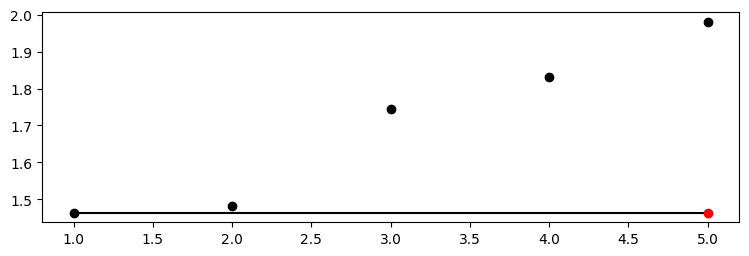

In [25]:
spot_tuner.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")

* Print the Results

In [26]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name       | type   | default          |   lower |   upper |                tuned | transform             |   importance | stars   |
|------------|--------|------------------|---------|---------|----------------------|-----------------------|--------------|---------|
| l1         | int    | 5                |     2.0 |     9.0 |                  8.0 | transform_power_2_int |         0.00 |         |
| l2         | int    | 5                |     2.0 |     9.0 |                  8.0 | transform_power_2_int |         0.00 |         |
| lr         | float  | 0.001            |   1e-05 |    0.01 | 0.003565720974200323 | None                  |       100.00 | ***     |
| batch_size | int    | 4                |     1.0 |     5.0 |                  2.0 | transform_power_2_int |         0.64 | .       |
| epochs     | int    | 3                |     3.0 |     4.0 |                  4.0 | transform_power_2_int |         0.00 |         |
| k_folds    | int    | 2                |     0.0 |   

## Show variable importance

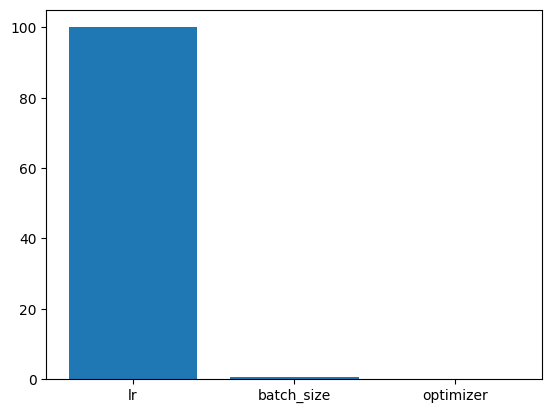

In [27]:
spot_tuner.plot_importance(threshold=0.025, filename="../Figures.d/" + experiment_name+"_importance.pdf")

## Get Default Hyperparameters

In [81]:
# from spotPython.hyperparameters.values import get_dict_with_levels_and_types
# values_default = get_default_values(fun_control)
# values_default = transform_hyper_parameter_values(fun_control=fun_control, hyper_parameter_values=values_default)
# get_dict_with_levels_and_types(fun_control, values_default)
# values_default

In [82]:
fc = fun_control.copy()
fc.update({"core_model_hyper_dict": hyper_dict[fun_control["core_model"].__name__]})
X_default = get_default_hyperparameters_as_array(fc, hyper_dict)
X_default


array([[5.0e+00, 5.0e+00, 1.0e-03, 4.0e+00, 3.0e+00, 2.0e+00, 5.0e+00,
        1.2e+01, 2.0e+00]])

In [83]:
model_default = get_one_core_model_from_X(X_start, fc)
model_default

Net_CIFAR10(
  (criterion): CrossEntropyLoss()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [84]:
model_default.optimizer

torch.optim.sgd.SGD

In [85]:
model_default.criterion

CrossEntropyLoss()

In [86]:

# v_dict_default = assign_values(X_default, fun_control["var_name"])
# v_dict_default
# #return_conf_list_from_var_dict(var_dict=v_dict_default, fun_control=fun_control)

In [87]:
# fc = fun_control
# fc.update({"core_model_hyper_dict": hyper_dict[fun_control["core_model"].__name__]})
# fc

In [88]:
# values_default=return_conf_list_from_var_dict(var_dict=v_dict_default, fun_control=fc)
# values_default

In [89]:
# model_default = fun_control["core_model"](**values_default)
# model_default

## Get SPOT Results

In [90]:
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
print(X)

[[8.00000000e+00 8.00000000e+00 3.56572097e-03 2.00000000e+00
  4.00000000e+00 0.00000000e+00 5.00000000e+00 0.00000000e+00
  0.00000000e+00]]


In [91]:
v_dict = assign_values(X, fun_control["var_name"])
v_dict


{'l1': array([8.]),
 'l2': array([8.]),
 'lr': array([0.00356572]),
 'batch_size': array([2.]),
 'epochs': array([4.]),
 'k_folds': array([0.]),
 'patience': array([5.]),
 'optimizer': array([0.]),
 'criterion': array([0.])}

In [92]:
return_conf_list_from_var_dict(var_dict=v_dict, fun_control=fun_control)

[{'l1': 256,
  'l2': 256,
  'lr': 0.003565720974200323,
  'batch_size': 4,
  'epochs': 16,
  'k_folds': 0,
  'patience': 5,
  'optimizer': torch.optim.sgd.SGD,
  'criterion': CrossEntropyLoss()}]

In [93]:
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_CIFAR10(
  (criterion): CrossEntropyLoss()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

## Evaluations

The method `train_save` takes a model architecture without trained weights and trains this model with the train data. The train data is split into train and validation data. The validation data is used for early stopping. The trained model model_state_dict is saved.

 This evaluation is similar to the final Evaluation as in the Pytorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html).

In [94]:
model_default

Net_CIFAR10(
  (criterion): CrossEntropyLoss()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [95]:
train_save(net=model_default, train_dataset=train, shuffle=True, device = "cpu", show_batch_interval=1_000, path="model_default_trained.pt", save_model=True)

Epoch: 1
Batch:  1000. Batch Size: 16. Training Loss (running): 2.308
Loss on hold-out set: 2.3063798971176146
Accuracy on hold-out set: 0.0984
Epoch: 2
Batch:  1000. Batch Size: 16. Training Loss (running): 2.305
Loss on hold-out set: 2.3040632904052734
Accuracy on hold-out set: 0.09325
Epoch: 3
Batch:  1000. Batch Size: 16. Training Loss (running): 2.303
Loss on hold-out set: 2.302003882598877
Accuracy on hold-out set: 0.1062
Epoch: 4
Batch:  1000. Batch Size: 16. Training Loss (running): 2.301
Loss on hold-out set: 2.299362413215637
Accuracy on hold-out set: 0.11115
Epoch: 5
Batch:  1000. Batch Size: 16. Training Loss (running): 2.298
Loss on hold-out set: 2.295009426879883
Accuracy on hold-out set: 0.1419
Epoch: 6
Batch:  1000. Batch Size: 16. Training Loss (running): 2.293
Loss on hold-out set: 2.2859293588638305
Accuracy on hold-out set: 0.16755
Epoch: 7
Batch:  1000. Batch Size: 16. Training Loss (running): 2.282
Loss on hold-out set: 2.2624968313217164
Accuracy on hold-out set:

(2.190771304321289, nan)

In [96]:
test_saved(net=model_default, test_dataset=test, shuffle=False, device = "cpu", show_batch_interval=1_000, path="model_default_trained.pt")

Loss on hold-out set: 2.1896024574279784
Accuracy on hold-out set: 0.1902
Returned to Spot: Validation loss: 2.1896024574279784
----------------------------------------------


(2.1896024574279784, nan)

In [97]:
model_spot

Net_CIFAR10(
  (criterion): CrossEntropyLoss()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [98]:

train_save(net=model_spot, train_dataset=train, shuffle=True, device = "cpu", show_batch_interval=1_000, path="model_spot_trained.pt", save_model=True)

Epoch: 1
Batch:  1000. Batch Size: 4. Training Loss (running): 2.300
Batch:  2000. Batch Size: 4. Training Loss (running): 1.142
Batch:  3000. Batch Size: 4. Training Loss (running): 0.734
Batch:  4000. Batch Size: 4. Training Loss (running): 0.527
Batch:  5000. Batch Size: 4. Training Loss (running): 0.407
Batch:  6000. Batch Size: 4. Training Loss (running): 0.336
Batch:  7000. Batch Size: 4. Training Loss (running): 0.283
Loss on hold-out set: 1.9725347606420518
Accuracy on hold-out set: 0.2826
Epoch: 2
Batch:  1000. Batch Size: 4. Training Loss (running): 1.975
Batch:  2000. Batch Size: 4. Training Loss (running): 0.973
Batch:  3000. Batch Size: 4. Training Loss (running): 0.641
Batch:  4000. Batch Size: 4. Training Loss (running): 0.483
Batch:  5000. Batch Size: 4. Training Loss (running): 0.380
Batch:  6000. Batch Size: 4. Training Loss (running): 0.321
Batch:  7000. Batch Size: 4. Training Loss (running): 0.269
Loss on hold-out set: 1.890852786719799
Accuracy on hold-out set: 0.

(1.4803974281966685, nan)

In [99]:
test_saved(net=model_spot, test_dataset=test, shuffle=False, device = "cpu", show_batch_interval=1_000, path="model_spot_trained.pt")

Loss on hold-out set: 1.477110841304064
Accuracy on hold-out set: 0.4698
Returned to Spot: Validation loss: 1.477110841304064
----------------------------------------------


(1.477110841304064, nan)

In [100]:
model_spot.optimizer

torch.optim.sgd.SGD

In [101]:
model_default.optimizer

torch.optim.sgd.SGD

## Detailed Hyperparameter Plots

* For productive use, you might want to select:
  * `min_z=min(spot_tuner.y)` and
  * `max_z = max(spot_tuner.y)`
* These settings are not so colorful as visualizations that use `None` for the ranges, but give better insights.

lr:  100.0
batch_size:  0.6432994226785285
optimizer:  0.13161986873373838


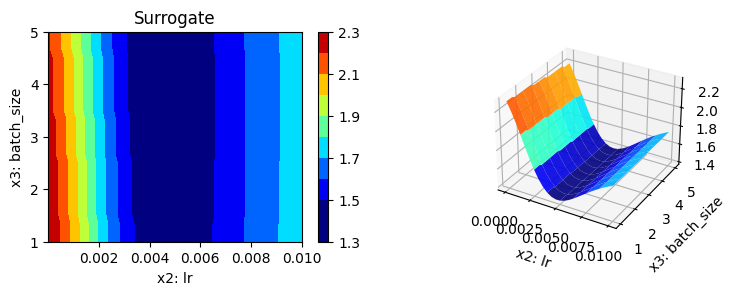

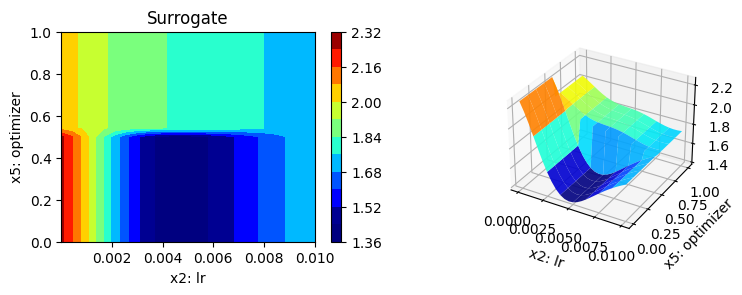

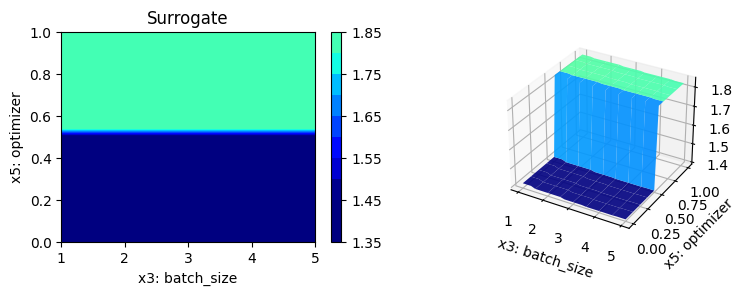

In [102]:
threshold = 0.025
impo = spot_tuner.print_importance(threshold=threshold, print_screen=True)
var_plots = [i for i, x in enumerate(impo) if x[1] > threshold]
min_z = min(spot_tuner.y)
max_z = max(spot_tuner.y)
n = spot_tuner.k
for i in var_plots:
    for j in var_plots:
        if j > i:
            filename = "../Figures.d/" + experiment_name+"_contour_"+str(i)+"_"+str(j)+".pdf"
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z, filename=filename)

## Parallel Coordinates Plot

In [103]:
spot_tuner.parallel_plot()

# Additional Evaluations

Two evaluations are performed: First, the test data is used only: the test data is used for training the model and for evaluating the model. Second, the train and test data are used: the model is trained with the train data and evaluated with the test data.

## Test Set Accuracy

The tuned model architecture (i.e., the model without pre-trained weights) is used for training and testing the model with the test data.
The default model is considered first.

In [104]:
evaluate_hold_out(net=model_default, train_dataset=test, shuffle=False, show_batch_interval=1_000)

Epoch: 1
Loss on hold-out set: 2.1705886907577514
Accuracy on hold-out set: 0.2015
Epoch: 2
Loss on hold-out set: 2.152968276977539
Accuracy on hold-out set: 0.2065
Epoch: 3
Loss on hold-out set: 2.1363483033180235
Accuracy on hold-out set: 0.21025
Epoch: 4
Loss on hold-out set: 2.120564787864685
Accuracy on hold-out set: 0.2165
Epoch: 5
Loss on hold-out set: 2.105536873817444
Accuracy on hold-out set: 0.23475
Epoch: 6
Loss on hold-out set: 2.0912453145980834
Accuracy on hold-out set: 0.23875
Epoch: 7
Loss on hold-out set: 2.078020172595978
Accuracy on hold-out set: 0.241
Epoch: 8
Loss on hold-out set: 2.066112644195557
Accuracy on hold-out set: 0.242
Returned to Spot: Validation loss: 2.066112644195557
----------------------------------------------


(2.066112644195557, nan)

In [105]:
evaluate_hold_out(net=model_spot, train_dataset=test, shuffle=False, show_batch_interval=1_000)

Epoch: 1
Batch:  1000. Batch Size: 4. Training Loss (running): 1.476
Loss on hold-out set: 1.4558526830375194
Accuracy on hold-out set: 0.478
Epoch: 2
Batch:  1000. Batch Size: 4. Training Loss (running): 1.463
Loss on hold-out set: 1.4547708805203439
Accuracy on hold-out set: 0.47925
Epoch: 3
Batch:  1000. Batch Size: 4. Training Loss (running): 1.454
Loss on hold-out set: 1.4536838866472244
Accuracy on hold-out set: 0.4785
Epoch: 4
Batch:  1000. Batch Size: 4. Training Loss (running): 1.447
Loss on hold-out set: 1.4532251760661603
Accuracy on hold-out set: 0.47725
Epoch: 5
Batch:  1000. Batch Size: 4. Training Loss (running): 1.441
Loss on hold-out set: 1.452761049926281
Accuracy on hold-out set: 0.477
Epoch: 6
Batch:  1000. Batch Size: 4. Training Loss (running): 1.435
Loss on hold-out set: 1.4519900446534157
Accuracy on hold-out set: 0.4775
Epoch: 7
Batch:  1000. Batch Size: 4. Training Loss (running): 1.429
Loss on hold-out set: 1.451197703167796
Accuracy on hold-out set: 0.47775


(1.445540370747447, nan)

## Train on Train Data and Test on Test Data (Hold-Out)

The final evaluation is performed with the train and test data. The model (without pre-trained weights) is trained with the train data and evaluated with the test data.

In [106]:
evaluate_hold_out(net=model_default, train_dataset=train, shuffle=False, test_dataset=test, show_batch_interval=1_000) 

Epoch: 1
Batch:  1000. Batch Size: 16. Training Loss (running): 2.050
Batch:  2000. Batch Size: 16. Training Loss (running): 1.015
Batch:  3000. Batch Size: 16. Training Loss (running): 0.673
Loss on hold-out set: 2.002215056037903
Accuracy on hold-out set: 0.2707
Epoch: 2
Batch:  1000. Batch Size: 16. Training Loss (running): 2.003
Batch:  2000. Batch Size: 16. Training Loss (running): 0.995
Batch:  3000. Batch Size: 16. Training Loss (running): 0.662
Loss on hold-out set: 1.9723062437057495
Accuracy on hold-out set: 0.2872
Epoch: 3
Batch:  1000. Batch Size: 16. Training Loss (running): 1.975
Batch:  2000. Batch Size: 16. Training Loss (running): 0.982
Batch:  3000. Batch Size: 16. Training Loss (running): 0.654
Loss on hold-out set: 1.9474575384140014
Accuracy on hold-out set: 0.302
Epoch: 4
Batch:  1000. Batch Size: 16. Training Loss (running): 1.951
Batch:  2000. Batch Size: 16. Training Loss (running): 0.970
Batch:  3000. Batch Size: 16. Training Loss (running): 0.647
Loss on hold

(1.8693161859512328, nan)

In [107]:
evaluate_hold_out(net=model_spot, train_dataset=train, shuffle=False, test_dataset=test, show_batch_interval=1_000)

Epoch: 1
Batch:  1000. Batch Size: 4. Training Loss (running): 1.419
Batch:  2000. Batch Size: 4. Training Loss (running): 0.713
Batch:  3000. Batch Size: 4. Training Loss (running): 0.481
Batch:  4000. Batch Size: 4. Training Loss (running): 0.367
Batch:  5000. Batch Size: 4. Training Loss (running): 0.283
Batch:  6000. Batch Size: 4. Training Loss (running): 0.234
Batch:  7000. Batch Size: 4. Training Loss (running): 0.200
Batch:  8000. Batch Size: 4. Training Loss (running): 0.176
Batch:  9000. Batch Size: 4. Training Loss (running): 0.165
Batch: 10000. Batch Size: 4. Training Loss (running): 0.143
Batch: 11000. Batch Size: 4. Training Loss (running): 0.130
Batch: 12000. Batch Size: 4. Training Loss (running): 0.118
Loss on hold-out set: 1.3902002653837204
Accuracy on hold-out set: 0.4993
Epoch: 2
Batch:  1000. Batch Size: 4. Training Loss (running): 1.384
Batch:  2000. Batch Size: 4. Training Loss (running): 0.698
Batch:  3000. Batch Size: 4. Training Loss (running): 0.472
Batch:  

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [ ]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)